<a href="https://colab.research.google.com/github/Aadityesha/PlantDiseaseDetection/blob/main/Potato_Disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "E:\Disease Classification\Potato",
  shuffle=True,
  image_size = (IMAGE_SIZE,IMAGE_SIZE),
  batch_size = BATCH_SIZE
) 

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0]


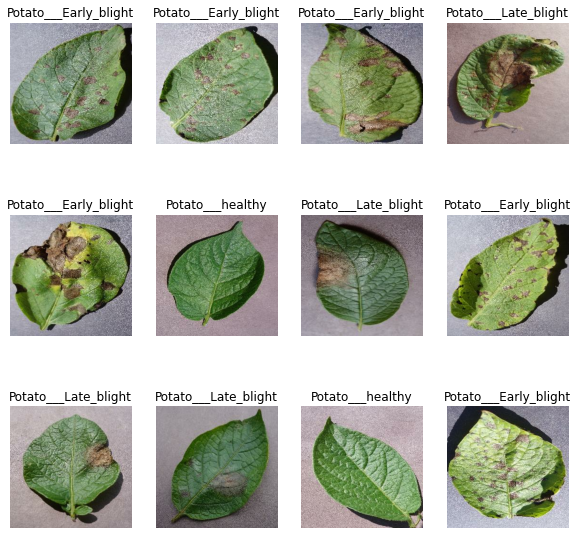

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [13]:
len(dataset)

68

In [14]:
train_size = 0.8
val_size = 0.1
test_size = 0.1
print(len(dataset)*train_size)
print(len(dataset)*val_size)
print(len(dataset)*test_size)

54.400000000000006
6.800000000000001
6.800000000000001


In [15]:
train_ds = dataset.take(54)
rest_ds = dataset.skip(54)
val_ds = rest_ds.take(6)
test_size = rest_ds.skip(6)

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)
  
  train_ds = ds.take(train_size)
  rest_ds = ds.skip(train_size)
  val_ds = rest_ds.take(val_size)
  test_ds = rest_ds.skip(val_size)

  return train_ds, val_ds, test_size

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 109s 2s/step - loss: 0.9038 - accuracy: 0.4722 - val_loss: 0.9753 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 94s 2s/step - loss: 0.7798 - accuracy: 0.5903 - val_loss: 0.6706 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 92s 2s/step - loss: 0.5355 - accuracy: 0.7477 - val_loss: 0.5365 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 96s 2s/step - loss: 0.3914 - accuracy: 0.8397 - val_loss: 0.5561 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 94s 2s/step - loss: 0.3027 - accuracy: 0.8837 - val_loss: 0.2370 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 96s 2s/step - loss: 0.2227 - accuracy: 0.9225 - val_loss: 0.1892 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 97s 2s/step - loss: 0.1849 - accuracy: 0.9294 - val_loss: 0.2814 - val_accuracy: 0.9010
Epoch 8/50
54/54 [=